In [1]:
GCP_PROJECTS = !gcloud config get-value project
PROJECT_ID = GCP_PROJECTS[0]
PROJECT_NUM = !gcloud projects list --filter="$PROJECT_ID" --format="value(PROJECT_NUMBER)"
PROJECT_NUM = PROJECT_NUM[0]
LOCATION = 'us-central1'
REGION = "us-central1"

# VERTEX_SA = '934903580331-compute@developer.gserviceaccount.com'
VERTEX_SA = 'jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com'

print(f"PROJECT_ID: {PROJECT_ID}")
print(f"PROJECT_NUM: {PROJECT_NUM}")
print(f"LOCATION: {LOCATION}")
print(f"REGION: {REGION}")
print(f"VERTEX_SA: {VERTEX_SA}")

PROJECT_ID: hybrid-vertex
PROJECT_NUM: 934903580331
LOCATION: us-central1
REGION: us-central1
VERTEX_SA: jt-vertex-sa@hybrid-vertex.iam.gserviceaccount.com


In [2]:
REGION = 'us-central1'
EXPERIMENT = 'control_group1'
SERIES = 'causal_impact_4'

BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-','_')
BQ_TABLE = EXPERIMENT

BQ_SOURCE1 = 'bigquery-public-data.new_york.citibike_trips'
BQ_SOURCE2 = 'bigquery-public-data.new_york.citibike_stations'

viz_limit = 9

In [3]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from time import sleep

from google.cloud import aiplatform as vertex_ai

bq = bigquery.Client(project=PROJECT_ID)

vertex_ai.init(
    project=PROJECT_ID, 
    location=REGION,
    # credentials=credentials
)

In [21]:
# CUSTOMIZE
TARGET_COLUMN = 'num_trips'
TIME_COLUMN = 'starttime'
SERIES_COLUMN = 'start_station_name'
SPLIT_COLUMN = 'splits'
COVARIATE_COLUMNS = [
    'avg_tripduration', 
    'pct_subscriber', 
    'ratio_gender', 
    'capacity'
] # could be empty

BQ_TABLE_GROUP_A="control_group1_grp_a"
# BQ_TABLE_GROUP_B="control_group1_grp_b"

forecast_granularity = 'DAY'
forecast_horizon = 7 #14
forecast_test_length = 14
#forecast_val_length = 14

In [5]:
query = f"""
    WITH
        SPLIT AS (
            SELECT splits, min({TIME_COLUMN}) as mindate, max({TIME_COLUMN}) as maxdate
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}`
            GROUP BY splits
        ),
        TRAIN AS (
            SELECT mindate as start_date
            FROM SPLIT
            WHERE splits ='TRAIN'
        ),
        VAL AS (
            SELECT mindate as val_start
            FROM SPLIT
            WHERE splits = 'VALIDATE'
        ),
        TEST AS (
            SELECT mindate as test_start, maxdate as end_date
            FROM SPLIT
            WHERE splits = 'TEST'
        )
    SELECT * EXCEPT(pos) FROM
    (SELECT *, ROW_NUMBER() OVER() pos FROM TRAIN)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM VAL)
    USING (pos)
    JOIN (SELECT *, ROW_NUMBER() OVER() pos FROM TEST)
    USING (pos)
"""
keyDates = bq.query(query).to_dataframe()
keyDates

start_date   val_start  test_start    end_date
0  2013-07-01  2016-05-14  2016-07-23  2016-09-30

In [6]:
query = f"""
    SELECT {SERIES_COLUMN}, {TIME_COLUMN}, {TARGET_COLUMN}, splits,
        {', '.join(COVARIATE_COLUMNS)}
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}`
    ORDER by {SERIES_COLUMN}, {TIME_COLUMN}
"""
rawSeries = bq.query(query).to_dataframe()

## plot time series

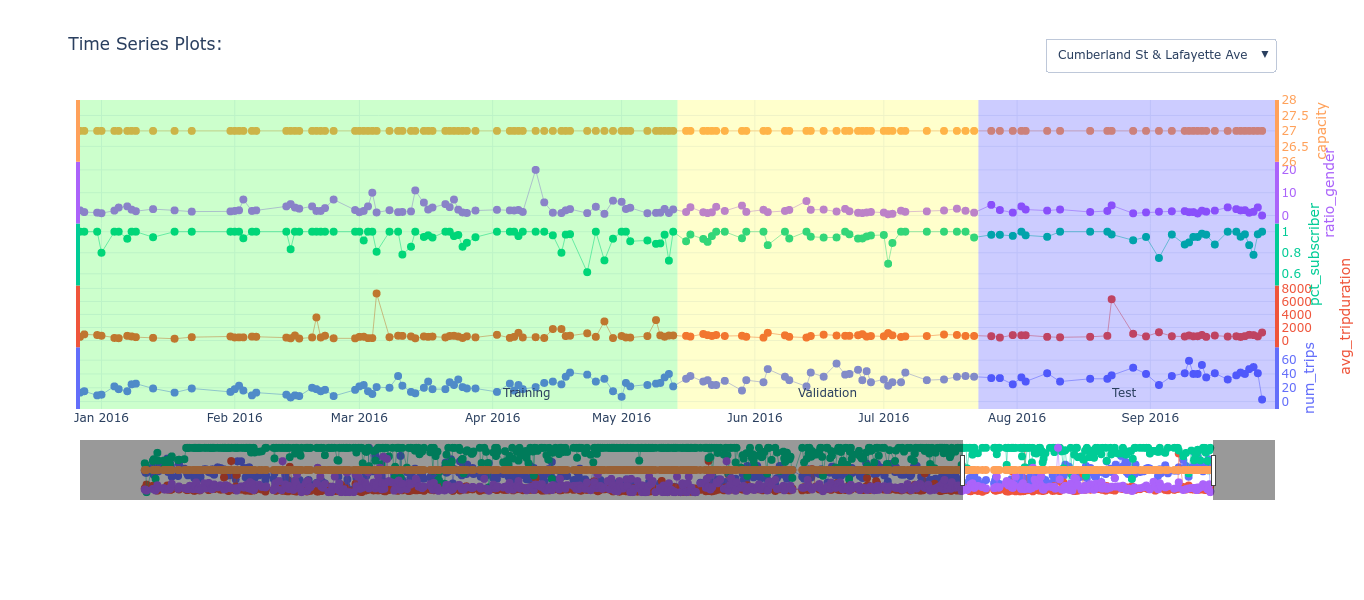

In [7]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] + COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
    
    # which button to show:
    ff = 0 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

In [ ]:
# print('A Snapshot of the interactive plot:')
# fig.show('png')

# Example 1: linear regression

* Prediction - What is demand today based on
> * Covariates
> * Using Time Features: Week, Month, Year, Day, ...

Regression methods don't know about time/date based data types. To get started, lets first decompose the TIME_COLUMN into parts like year, month, day, day of week and model with a linear regression to find the optimal weights of these components.

In [10]:
EX1_CTE = f"""
WITH EX1_CTE AS (
    SELECT
        {TARGET_COLUMN},
        {SERIES_COLUMN},
        {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)},
        
        # TIME FEATURES
        EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
        EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
        EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
        EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
        EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
        CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,
        
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}`
)
"""

In [11]:
BQ_MODEL = f"{BQ_TABLE_GROUP_A}_reg_ex1"
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['{TARGET_COLUMN}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
    {EX1_CTE}
    SELECT
        * EXCEPT({SPLIT_COLUMN}),
        CASE
            WHEN {SPLIT_COLUMN} = 'TRAIN' THEN FALSE
            ELSE TRUE
        END AS custom_splits
    FROM EX1_CTE
    WHERE {SPLIT_COLUMN} in ('TRAIN', 'VALIDATE')
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 13.304


In [12]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')


Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=hybrid-vertex&ws=!1m5!1m4!5m3!1shybrid-vertex!2scausal_impact_4!3scontrol_group1_grp_a_reg_ex1


In [13]:
query = f"""
SELECT *
FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
weights = bq.query(query = query).to_dataframe()
weights

processed_input        weight  \
0   start_station_name           NaN   
1     avg_tripduration      0.001050   
2       pct_subscriber    -38.113269   
3         ratio_gender     -3.368427   
4             capacity     -0.098005   
5                 Year     11.889496   
6                Month    408.808241   
7         Day_of_Month     13.199268   
8          Day_of_Year    -13.334926   
9          Day_of_Week      0.622661   
10             Weekend    -15.605724   
11       __INTERCEPT__ -24358.012491   

                                     category_weights  
0   [{'category': 'Lafayette St & Jersey St', 'wei...  
1                                                  []  
2                                                  []  
3                                                  []  
4                                                  []  
5                                                  []  
6                                                  []  
7                                                  []  
8                                                  []  
9                                                  []  
10                                                 []  
11                                                 []

In [14]:
weights['category_weights'].iloc[0]

array([{'category': 'Lafayette St & Jersey St', 'weight': 152.2223854597137},
       {'category': 'Lafayette Ave & Classon Ave', 'weight': 34.84708337403104},
       {'category': 'Clermont Ave & Lafayette Ave', 'weight': 39.755687738130156},
       {'category': 'Lafayette St & E 8 St', 'weight': 274.58219335113955},
       {'category': 'Cumberland St & Lafayette Ave', 'weight': 44.58769368619443},
       {'category': 'Marcy Ave & Lafayette Ave', 'weight': 6.305507749522765},
       {'category': 'Lafayette Ave & Fort Greene Pl', 'weight': 41.49836377912928},
       {'category': 'Lafayette Ave & St James Pl', 'weight': 37.53481657889505}],
      dtype=object)

In [15]:
query = f"""
{EX1_CTE}
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX1_CTE WHERE {SPLIT_COLUMN} = 'TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX1_CTE WHERE {SPLIT_COLUMN} = 'VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX1_CTE WHERE {SPLIT_COLUMN} = 'TRAIN'))
"""
bq.query(query = query).to_dataframe()

SPLIT  mean_absolute_error  mean_squared_error  mean_squared_log_error  \
0      TEST            16.621352          934.125983                0.451237   
1     TRAIN            29.571125         2207.168762                0.770508   
2  VALIDATE            35.507524         4866.625659                0.782135   

   median_absolute_error  r2_score  explained_variance  
0              10.182352  0.582279            0.594326  
1              15.813458  0.758835            0.758835  
2              10.662942  0.591981            0.643513

## custom metrics

In [16]:
query = f"""
{EX1_CTE},
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`, (
                SELECT *
                FROM EX1_CTE
                WHERE {SPLIT_COLUMN} = 'TEST'
            ))
        )
    SELECT {SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex1 = bq.query(query = query).to_dataframe()
customMetrics_ex1

start_station_name      MAPE         MAE      pMAE  \
0    Clermont Ave & Lafayette Ave  0.314387    9.202792  0.306760   
1   Cumberland St & Lafayette Ave  0.623156    9.281695  0.248540   
2     Lafayette Ave & Classon Ave  0.288933    9.756228  0.297095   
3  Lafayette Ave & Fort Greene Pl  0.276956   11.358976  0.275787   
4     Lafayette Ave & St James Pl  0.347796   11.016199  0.336372   
5           Lafayette St & E 8 St  1.330045  116.578147  0.806211   
6        Lafayette St & Jersey St  0.318372   72.540416  0.341732   
7       Marcy Ave & Lafayette Ave  1.062152   13.492219  1.057122   

            MSE        RMSE     pRMSE  
0    137.547156   11.728050  0.390935  
1    180.443225   13.432916  0.359699  
2    167.348412   12.936321  0.393935  
3    191.690571   13.845236  0.336151  
4    177.872694   13.336892  0.407233  
5  17004.090695  130.399734  0.901796  
6   6594.808631   81.208427  0.382566  
7    272.677960   16.512963  1.293799

In [17]:
query = f"""
{EX1_CTE},
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`, (
                SELECT *
                FROM EX1_CTE
                WHERE {SPLIT_COLUMN} = 'TEST'
            ))
        )
    SELECT #{SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    #GROUP BY {SERIES_COLUMN}
    #ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex1 = bq.query(query = query).to_dataframe()
customMetrics_ex1

MAPE        MAE      pMAE         MSE       RMSE     pRMSE
0  0.514261  16.621352  0.388018  934.125983  30.563475  0.713491

In [18]:
query = f"""
{EX1_CTE}
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT *
    FROM EX1_CTE
    )
  )
ORDER BY Year, Month, Day_of_Month
"""
pred_ex1 = bq.query(query = query).to_dataframe()

In [19]:
pred_ex1

start_station_name   starttime   predicted
0              Lafayette St & E 8 St  2013-07-01  252.046035
1        Lafayette Ave & St James Pl  2013-07-01   19.724006
2       Clermont Ave & Lafayette Ave  2013-07-01   25.033210
3        Lafayette Ave & Classon Ave  2013-07-02    5.342521
4      Cumberland St & Lafayette Ave  2013-07-02   31.581958
...                              ...         ...         ...
4254  Lafayette Ave & Fort Greene Pl  2016-09-28   37.586630
4255        Lafayette St & Jersey St  2016-09-29  137.282949
4256  Lafayette Ave & Fort Greene Pl  2016-09-29   35.917753
4257    Clermont Ave & Lafayette Ave  2016-09-29   27.761451
4258    Clermont Ave & Lafayette Ave  2016-09-30   26.170867

[4259 rows x 3 columns]

### plot time series

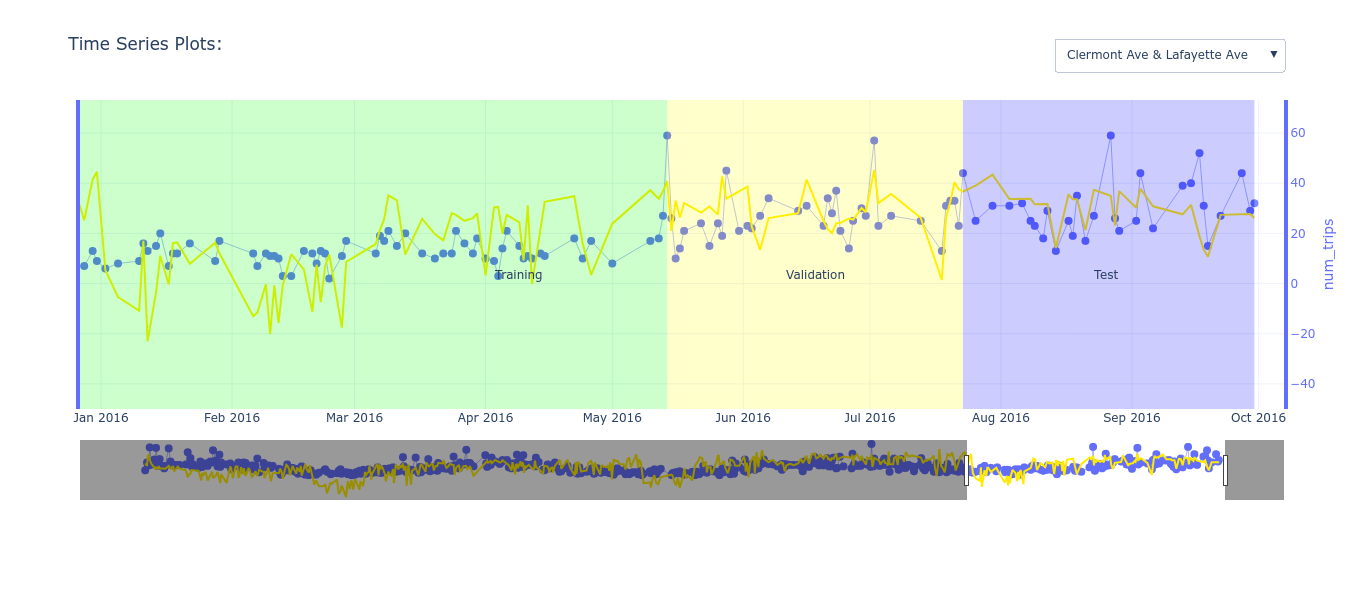

In [22]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = pred_ex1[pred_ex1[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex1[pred_ex1[SERIES_COLUMN]==s]['predicted'],
                    name = f'Forecast: {v}',
                    text = pred_ex1[pred_ex1[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 1 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = forecast_horizon),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = forecast_horizon)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = forecast_horizon)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()

# Example 2: Linear Regression + Lags

* Prediction - What is demand today based on
> * Covariates
> * Using Time Features: Week, Month, Year, Day, ...
> * Using Lags for 1 day, 1 week (7), 1 month (28), 1 quarter (90), 1 year

In [23]:
EX2_CTE = f"""
WITH EX2_CTE AS (
    SELECT
        {TARGET_COLUMN},
        {SERIES_COLUMN},
        {SPLIT_COLUMN},
        {', '.join(COVARIATE_COLUMNS)},
        
        # TIME FEATURES
        EXTRACT(YEAR FROM {TIME_COLUMN}) AS Year,
        EXTRACT(MONTH FROM {TIME_COLUMN}) AS Month,
        EXTRACT(DAY FROM {TIME_COLUMN}) AS Day_of_Month,
        EXTRACT(DAYOFYEAR FROM {TIME_COLUMN}) AS Day_of_Year,
        EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) AS Day_of_Week,
        CASE WHEN EXTRACT(DAYOFWEEK FROM {TIME_COLUMN}) IN (1, 7) THEN 1 ELSE 0 END AS Weekend,
        
        # LAGs
        LAG({TARGET_COLUMN}, 1) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1day,
        LAG({TARGET_COLUMN}, 7) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1week,
        LAG({TARGET_COLUMN}, 28) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1month,
        LAG({TARGET_COLUMN}, 90) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1quarter,
        LAG({TARGET_COLUMN}, 365) OVER(PARTITION BY {SERIES_COLUMN} ORDER BY {TIME_COLUMN}) AS lag_1year
        
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE_GROUP_A}`
)
"""

In [24]:
BQ_MODEL = f"{BQ_TABLE}_reg_ex2"
query = f"""
CREATE OR REPLACE MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`
    OPTIONS (
        model_type = 'LINEAR_REG',
        input_label_cols = ['{TARGET_COLUMN}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
    {EX2_CTE}
    SELECT
        * EXCEPT({SPLIT_COLUMN}),
        CASE
            WHEN {SPLIT_COLUMN} = 'TRAIN' THEN FALSE
            ELSE TRUE
        END AS custom_splits
    FROM EX2_CTE
    WHERE {SPLIT_COLUMN} in ('TRAIN', 'VALIDATE')
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 16.084


In [25]:
print(f'Direct link to the model in BigQuery:\nhttps://console.cloud.google.com/bigquery?project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET}!3s{BQ_MODEL}')


Direct link to the model in BigQuery:
https://console.cloud.google.com/bigquery?project=hybrid-vertex&ws=!1m5!1m4!5m3!1shybrid-vertex!2scausal_impact_4!3scontrol_group1_reg_ex2


In [26]:
query = f"""
SELECT *
FROM ML.WEIGHTS (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`)
"""
weights = bq.query(query = query).to_dataframe()
weights

processed_input       weight  \
0   start_station_name          NaN   
1     avg_tripduration     0.000663   
2       pct_subscriber   -20.957920   
3         ratio_gender    -1.251591   
4             capacity     0.045520   
5                 Year     3.386218   
6                Month   105.713664   
7         Day_of_Month     3.403234   
8          Day_of_Year    -3.466698   
9          Day_of_Week     0.139019   
10             Weekend   -13.832510   
11            lag_1day     0.518223   
12           lag_1week     0.213678   
13          lag_1month     0.020715   
14        lag_1quarter    -0.061994   
15           lag_1year     0.078585   
16       __INTERCEPT__ -6941.370471   

                                     category_weights  
0   [{'category': 'Lafayette Ave & Fort Greene Pl'...  
1                                                  []  
2                                                  []  
3                                                  []  
4                                                  []  
5                                                  []  
6                                                  []  
7                                                  []  
8                                                  []  
9                                                  []  
10                                                 []  
11                                                 []  
12                                                 []  
13                                                 []  
14                                                 []  
15                                                 []  
16                                                 []

In [27]:
weights['category_weights'].iloc[0]

array([{'category': 'Lafayette Ave & Fort Greene Pl', 'weight': 40.78721246529542},
       {'category': 'Lafayette St & E 8 St', 'weight': 101.08720478316428},
       {'category': 'Lafayette St & Jersey St', 'weight': 69.08308332384492},
       {'category': 'Cumberland St & Lafayette Ave', 'weight': 39.86210439553534},
       {'category': 'Lafayette Ave & Classon Ave', 'weight': 36.880660014868226},
       {'category': 'Clermont Ave & Lafayette Ave', 'weight': 36.694244109643925},
       {'category': 'Lafayette Ave & St James Pl', 'weight': 36.75839713385559},
       {'category': 'Marcy Ave & Lafayette Ave', 'weight': 26.65501535416774}],
      dtype=object)

### Prediction with Lags

It is tricky. In using the 'TEST' split for predictions, each day has the actual data for lags. In a real forecasting horizon you will not know these values. For this reason you can only fully predict the first day of the horizon with a one step model like this one. To predict further out you need to recursively feed each forecast back into the same model as a lag for the next step. This does accumulate errors though. An alternative to this try a multi-step moel - see Example 3.

The example here does a recursive prediction.

In [28]:
test_start = keyDates['test_start'].iloc[0]
test_start.year, test_start.month, test_start.day

(2016, 7, 23)

In [29]:
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` AS
{EX2_CTE}
SELECT * EXCEPT(lag_1day, lag_1week),
    CASE
        WHEN DATE(year, month, day_of_month)> DATE({test_start.year},{test_start.month},{test_start.day}) THEN NULL
        ELSE lag_1day
    END AS lag_1day,
    CASE
        WHEN DATE(year, month, day_of_month)> DATE_ADD(DATE({test_start.year},{test_start.month},{test_start.day}), INTERVAL 7 DAY) THEN NULL
        ELSE lag_1week
    END AS lag_1week,
    ROW_NUMBER() OVER(PARTITION BY {SERIES_COLUMN} ORDER BY year, month, day_of_month) as horizon_day
FROM EX2_CTE
WHERE {SPLIT_COLUMN} = 'TEST'
ORDER BY {SERIES_COLUMN}, year, month, day_of_month
"""
job = bq.query(query = query)
job.result()
print(job.state, (job.ended-job.started).total_seconds())

DONE 2.248


Recursively predict the values for the TEST Data and fill in lags (14 day horizon impact lags for day and week):

*Note from Mike: THERE MUST BE A BETTER WAY TO DO THE FOLLOWING...*
* I tried Recursive CTE but need to reference the base twice (1Day and 1Week) which fails

In [31]:
# PREDICTIONS FOR FIRST DAY OF HORIZON
query = f"""
CREATE OR REPLACE TABLE `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` AS
    SELECT *
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
        (
            SELECT *
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
            WHERE horizon_day = 1
        )
    )
"""
job = bq.query(query = query)
job.result()

query = f"""
SELECT column_name
FROM `{BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS`
WHERE table_name = '{BQ_MODEL}_TEST_DATA_RECURSIVE'
"""
columns_in_order = ', '.join(list(bq.query(query).to_dataframe()['column_name']))

# PREDICTION FOR SECOND DAY OF HORIZON TO LAST DAY OF HORIZON
horizon_length = (keyDates['end_date'].iloc[0] - keyDates['test_start'].iloc[0]).days + 1
for day in range(2, forecast_horizon + 1):
    query = f"""
    INSERT INTO `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
        WITH
            TODAY AS (
                SELECT * EXCEPT(lag_1day, lag_1week)
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA`
                WHERE horizon_day = {day}
            ),
            LAG_DAY AS (
                SELECT {SERIES_COLUMN}, CAST(FLOOR(predicted_{TARGET_COLUMN}) AS INT64) as lag_1day 
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
                WHERE horizon_day = {day-1} 
            ),
            LAG_WEEK AS (
                SELECT {SERIES_COLUMN}, CAST(FLOOR(predicted_{TARGET_COLUMN}) AS INT64) as lag_1week 
                FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
                WHERE horizon_day = {day-7} 
            ),
            CURRENT_DAY AS (
                SELECT * FROM
                    TODAY
                    JOIN LAG_DAY USING ({SERIES_COLUMN})
                    LEFT OUTER JOIN LAG_WEEK USING ({SERIES_COLUMN})
            )
        SELECT {columns_in_order}
        FROM  ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
            (SELECT * FROM CURRENT_DAY)
        )
    """
    job = bq.query(query = query)
    job.result()

### Evaluation Metrics
The evaluation result show three ways of looking at the test data range:

* `TEST - LEAKED` For days of the test horizon past day 1 the lag values are leaked from known data which likely over estimates the models performance
* `TEST - TRUNCATED` For days of the test horizon past day 1 the lag values remain null if they are from the test horizon
* `TEST - RECURSIVE` For days of the test horizon past day 1 the lag values are recursively retrieved from prior test days predictions.

In [32]:
query = f"""
{EX2_CTE}
# uses recursive predictions to get lags for next step in horizon
SELECT 'TEST - RECURSIVE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` WHERE {SPLIT_COLUMN} = 'TEST'))
UNION ALL
# Truncated does not have lags filled in out of range
SELECT 'TEST - TRUNCATED' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA` WHERE {SPLIT_COLUMN} = 'TEST'))
UNION ALL
# wrong has lags filled in from actual data but not practical for measuring forecasting horizon - leakage
SELECT 'TEST - LEAKED' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX2_CTE WHERE {SPLIT_COLUMN} = 'TEST'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX2_CTE WHERE {SPLIT_COLUMN} = 'VALIDATE'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,
    (SELECT * FROM EX2_CTE WHERE {SPLIT_COLUMN} = 'TRAIN'))
ORDER BY SPLIT
"""
bq.query(query = query).to_dataframe()

SPLIT  mean_absolute_error  mean_squared_error  \
0     TEST - LEAKED            11.890625          593.332308   
1  TEST - RECURSIVE            26.375823         1406.933739   
2  TEST - TRUNCATED            27.786704         1426.728871   
3             TRAIN            18.272348         1061.542276   
4          VALIDATE            23.647670         1988.079294   

   mean_squared_log_error  median_absolute_error  r2_score  explained_variance  
0                0.412956               7.273090  0.734674            0.734679  
1                0.352301              17.026631  0.679610            0.684570  
2                0.584120              23.184517  0.361997            0.443897  
3                0.478482               9.065234  0.884011            0.884011  
4                0.267835               8.912030  0.833319            0.837560

### Custom Evaluation Metrics

Since the Test region is being predicted using an ensemble of the multi-step models it is easier to customer calculate the metrics using SQL:

In [33]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
        )
    SELECT {SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    GROUP BY {SERIES_COLUMN}
    ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex2 = bq.query(query = query).to_dataframe()
customMetrics_ex2

start_station_name      MAPE        MAE      pMAE          MSE  \
0    Clermont Ave & Lafayette Ave  0.588097  16.809367  0.557657   308.273402   
1   Cumberland St & Lafayette Ave  0.541077  16.828411  0.518938   303.805289   
2     Lafayette Ave & Classon Ave  0.500483  13.492591  0.486846   200.752534   
3  Lafayette Ave & Fort Greene Pl  0.591818  18.289505  0.540196   369.961503   
4     Lafayette Ave & St James Pl  0.677091  13.103202  0.552545   263.851733   
5           Lafayette St & E 8 St  0.578232  51.528427  0.356351  3488.353774   
6        Lafayette St & Jersey St  0.351557  73.069667  0.376094  6672.275196   
7       Marcy Ave & Lafayette Ave  1.158124  15.071875  1.087661   242.887922   

        RMSE     pRMSE  
0  17.557716  0.582483  
1  17.430011  0.537489  
2  14.168717  0.511242  
3  19.234383  0.568104  
4  16.243514  0.684967  
5  59.062287  0.408453  
6  81.683996  0.420432  
7  15.584862  1.124681

In [34]:
query = f"""
    WITH
        DIFFS AS (
            SELECT {SERIES_COLUMN},  
                {TARGET_COLUMN} as actual_value,
                predicted_{TARGET_COLUMN} as forecast_value, 
                ({TARGET_COLUMN} - predicted_{TARGET_COLUMN}) as diff
            FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE`
        )
    SELECT #{SERIES_COLUMN}, 
            AVG(SAFE_DIVIDE(ABS(diff), actual_value)) as MAPE,
            AVG(ABS(diff)) as MAE,
            SAFE_DIVIDE(SUM(ABS(diff)), SUM(actual_value)) as pMAE,
            AVG(POW(diff, 2)) as MSE,
            SQRT(AVG(POW(diff, 2))) as RMSE,
            SAFE_DIVIDE(SQRT(AVG(POW(diff, 2))), AVG(actual_value)) as pRMSE
    FROM DIFFS
    #GROUP BY {SERIES_COLUMN}
    #ORDER BY {SERIES_COLUMN}    
"""
customMetrics_ex2 = bq.query(query = query).to_dataframe()
customMetrics_ex2

MAPE        MAE      pMAE          MSE       RMSE     pRMSE
0  0.624979  26.375823  0.443015  1406.933739  37.509115  0.630013

In [35]:
query = f"""
{EX2_CTE}
SELECT
    {SERIES_COLUMN},
    DATE(year, month, day_of_month) AS {TIME_COLUMN},
    predicted_{TARGET_COLUMN} AS predicted
FROM ML.PREDICT (MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}`,(
    SELECT * FROM EX2_CTE WHERE {SPLIT_COLUMN} in ('TRAIN', 'VALIDATE')
    UNION ALL
    SELECT * EXCEPT(horizon_day, predicted_{TARGET_COLUMN}) FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_MODEL}_TEST_DATA_RECURSIVE` WHERE {SPLIT_COLUMN} = 'TEST' 
    )
  )
ORDER BY Year, Month, Day_of_Month
"""
pred_ex2 = bq.query(query = query).to_dataframe()

In [36]:
pred_ex2

start_station_name   starttime   predicted
0              Lafayette St & E 8 St  2013-07-01  121.752774
1       Clermont Ave & Lafayette Ave  2013-07-01   57.347565
2        Lafayette Ave & St James Pl  2013-07-01   54.689709
3     Lafayette Ave & Fort Greene Pl  2013-07-02   59.679211
4      Cumberland St & Lafayette Ave  2013-07-02   58.883959
...                              ...         ...         ...
4100        Lafayette St & Jersey St  2016-09-12   92.089466
4101        Lafayette St & Jersey St  2016-09-15  175.584937
4102        Lafayette St & Jersey St  2016-09-16  139.391840
4103        Lafayette St & Jersey St  2016-09-18  158.718808
4104        Lafayette St & Jersey St  2016-09-19  196.330400

[4105 rows x 3 columns]

### plot series

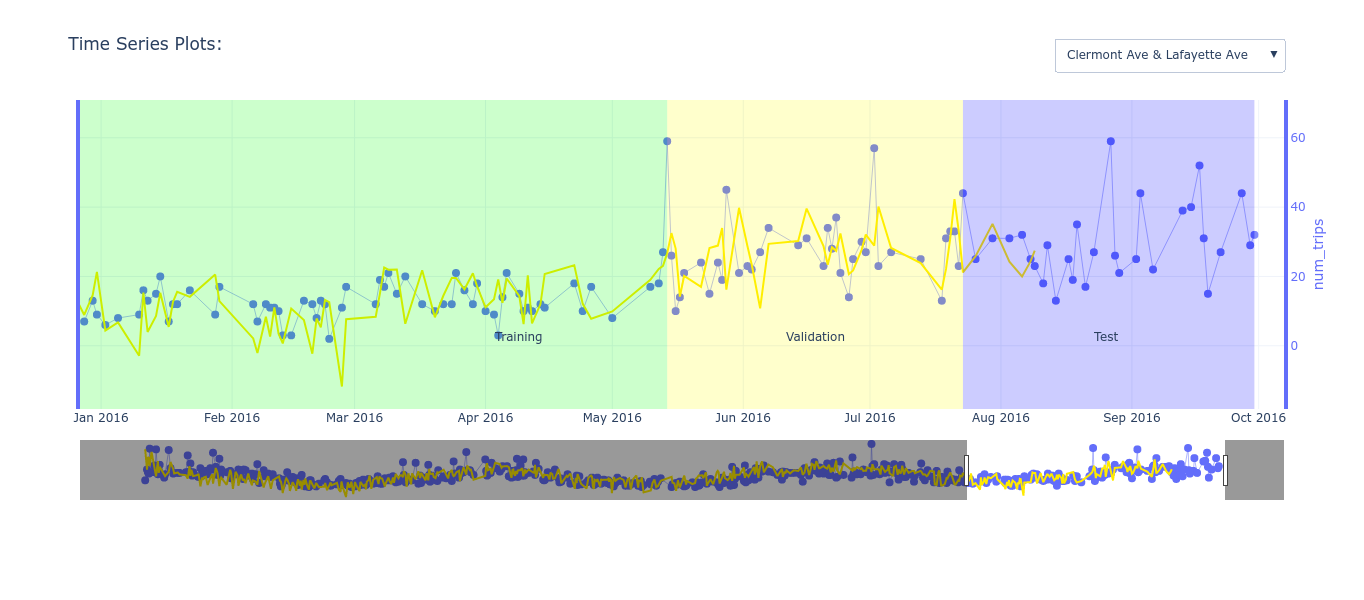

In [37]:
# NA values in Pandas will not convert to JSON which Plotly uses:
rawSeries = rawSeries.fillna(np.nan).replace([np.nan], [None])

# create a figure:
fig = go.Figure()

# get a list of colors to use:
colors = px.colors.qualitative.Plotly

# list of columns to plot over time : target and covariates
variables = [TARGET_COLUMN] #+ COVARIATE_COLUMNS

# create dropdown/button to toggle series
buttons = []
b = 0 # default button index

# iterate through series:
series = rawSeries[SERIES_COLUMN].unique().tolist()[0:viz_limit]
for s in series:    
    # iterate trhough columns
    for y, v in enumerate(variables):
        fig.add_trace(
            go.Scatter(
                x = rawSeries[rawSeries[SERIES_COLUMN]==s][TIME_COLUMN],
                y = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                name = f'{v}',
                text = rawSeries[rawSeries[SERIES_COLUMN]==s][v],
                yaxis = f"y{y+1}",
                hoverinfo='name+x+text',
                line = {'width': 0.5},
                marker = {'size': 8},
                mode = 'lines+markers',
                showlegend = False,
                visible = (b==0) # make a series visible as default: this uses the first series
            )
        )
        if y == 0: # add the forecast
            # add the forecast fit
            fig.add_trace(
                go.Scatter(
                    x = pred_ex2[pred_ex2[SERIES_COLUMN]==s][TIME_COLUMN],
                    y = pred_ex2[pred_ex2[SERIES_COLUMN]==s]['predicted'],
                    name = f'Forecast: {v}',
                    text = pred_ex2[pred_ex2[SERIES_COLUMN]==s]['predicted'],
                    yaxis = f"y{y+1}",
                    hoverinfo='name+x+text',
                    line = {'width': 2, 'color': 'rgb(255,234,0)'},
                    mode = 'lines',
                    showlegend = False,
                    visible = (b==0) # make a series visible as default: this uses the first series
                )
            )
    
    # which button to show:
    ff = 1 # count of forecast related traces add to each series
    which_buttons = [False] * len(series) * (len(variables) + ff)
    which_buttons[b * (len(variables) +ff):(b+1)*(len(variables) + ff)] = [True] * (len(variables) + ff)

    # create button for series:
    button = dict(
        label = s,
        method = 'update',
        args = [{'visible': which_buttons}]
    )
    buttons.append(button)
    b += 1

# add split regions: training
fig.add_shape(
    fillcolor = 'rgba(0, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['start_date'][0],
    x1 = keyDates['val_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] - (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Training',
    yanchor = 'bottom'
)

# add split regions: validation
fig.add_shape(
    fillcolor = 'rgba(255, 255, 0, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['val_start'][0],
    x1 = keyDates['test_start'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['val_start'][0] + (keyDates['test_start'][0]-keyDates['val_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Validation',
    yanchor = 'bottom'
)

# add split regions: test
fig.add_shape(
    fillcolor = 'rgba(0, 0, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['test_start'][0],
    x1 = keyDates['end_date'][0],
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['test_start'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Test',
    yanchor = 'bottom'
)

# add split regions: horizon
fig.add_shape(
    fillcolor = 'rgba(255, 255, 255, 0.2)',
    line = {'width': 0},
    type = 'rect',
    x0 = keyDates['end_date'][0],
    x1 = keyDates['end_date'][0]+timedelta(days = forecast_horizon),
    xref = 'x',
    y0 = 0,
    y1 = 1,
    yref = 'paper'
)
fig.add_annotation(
    x = keyDates['end_date'][0] + (keyDates['end_date'][0]-keyDates['test_start'][0])/2,
    y = 0,
    ax = 0, ay = 0,
    yref = 'y1',
    xref = 'x',
    text = 'Horizon',
    yanchor = 'bottom'
)

# configure axes layout:
layout = dict(
    xaxis =  dict(
        range = [keyDates['end_date'][0] - 2*(keyDates['end_date'][0] - keyDates['val_start'][0]), keyDates['end_date'][0]+timedelta(days = forecast_horizon)],
        rangeslider = dict(
            autorange = True,
            range = [keyDates['start_date'][0], keyDates['end_date'][0]+timedelta(days = forecast_horizon)]
        ),
        type = 'date'
    )
)
for v, variable in enumerate(variables):
    layout[f'yaxis{v+1}'] = dict(
        anchor = 'x',
        domain = [v*(1/len(variables)), (v+1)*(1/len(variables))],
        autorange = True,
        mirror = True,
        autoshift = True,
        title = dict(text = variable, standoff = 10 + 20 * (v % 2), font = dict(color = colors[v])),
        tickfont = dict(color = colors[v]),
        tickmode = 'auto',
        linecolor = colors[v],
        linewidth = 4,
        showline = True,
        side = 'right',
        type = 'linear',
        zeroline = False
    )

# final update of display before rendering
fig.update_layout(
    layout,
    title = 'Time Series Plots:',
    dragmode="zoom",
    hovermode="x",
    legend=dict(traceorder="reversed"),
    height=600,
    template="plotly_white",
    margin=dict(
        t=100,
        b=100
    ),
    updatemenus = [
        dict(
            buttons = buttons,
            type = 'dropdown',
            direction = 'down',
            x = 1,
            y = 1.2,
            showactive = True
        )
    ]
)

# render the interactive plot:
fig.show()